In [41]:
## Importing Libraries ##
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Import model
from baselines.wide_resnet import WideResNet

## Find and extract two images to be used in experiment

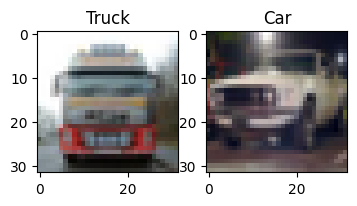

In [221]:
# Define a transform to normalize the data
normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
data_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize,
])

# Load the data 
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=data_transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=True, num_workers=2)

# Define the classes in CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Function to show an image
def imshow(img):
    # Undo the normalization for display purposes
    img = img * torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1) + torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # plt.show()

# Function to get a single image from a specific class
def get_image_from_class(loader, class_name):
    for idx, (images, labels) in enumerate(loader):
        if classes[labels[0]] == class_name:
            return images[0], labels[0], idx

# Get an image from the truck category
truck_img, truck_label, truck_idx = get_image_from_class(testloader, 'truck')
car_img, car_label, car_idx = get_image_from_class(testloader, 'car')
plt.figure(figsize=(4,2))
plt.subplot(1,2,1)
plt.title('Truck')
imshow(truck_img)
plt.subplot(1,2,2)
plt.title('Car')
imshow(car_img)
plt.show()


## Create interpolated images from these images 

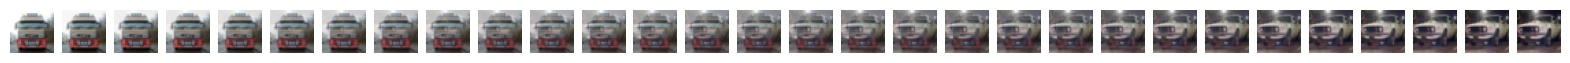

In [241]:
# Function to interpolate between two images
def interpolate_images(img1, img2, steps=10):
    interpolated_images = []
    for alpha in np.linspace(0, 1, steps):
        interpolated_image = (1 - alpha) * img1 + alpha * img2
        interpolated_images.append(interpolated_image)
    return interpolated_images

# Generate interpolated images (first image is original img1, last image is original img2, rest inbetween are interpolated)
num_images = 30
interpolated_images = interpolate_images(truck_img, car_img, steps=num_images)

plt.figure(figsize=(20, 5))
for i, img in enumerate(interpolated_images):
    plt.subplot(1, num_images, i+1)
    imshow(img)
    plt.axis('off')
plt.show()

In [187]:
# Load model architecture
model = WideResNet(depth=28, widen_factor=10, num_classes=10)

saved_model_path = 'deterministic_WR_model.pth'
# Load the model state dict
model.load_state_dict(torch.load(saved_model_path, map_location=torch.device('cpu')))

# Check if MPS is available
if torch.backends.mps.is_available():
    mps_device = torch.device('mps')
    model.to(mps_device)
    print("MPS device available, using MPS.")
else:
    print("MPS device not available, using CPU instead.")

# Evaluate images using the model
model.eval()
with torch.no_grad():
    output = model(truck_img.unsqueeze(0).to(mps_device))
    _, predicted = torch.max(output, 1)

    # Save softmax inputs and outputs to use for plot
    softmax_input = output # Logits before softmax
    softmax_output = torch.nn.functional.softmax(output, dim=1) # Softmax probabilities

print(f'Predicted: {classes[predicted[0]]}')

MPS device available, using MPS.
Predicted: truck


In [274]:
def collect_predictions(model, images, num_passes=1):
    model.eval()

    all_softmax_inputs = []
    all_softmax_outputs = []

    for img in images:
        softmax_inputs = []
        softmax_outputs = []
        img = img.unsqueeze(0).to(mps_device)  # Add batch dimension and move to device

        with torch.no_grad():
            for _ in range(num_passes):
                output = model(img)
                softmax_input = output  # Logits before softmax
                softmax_output = torch.nn.functional.softmax(output, dim=1)  # Softmax probabilities
                
                softmax_input = softmax_input.view(-1)
                softmax_output = softmax_output.view(-1)
                softmax_inputs.append(softmax_input.cpu().numpy())
                softmax_outputs.append(softmax_output.cpu().numpy())

        all_softmax_inputs.append(np.array(softmax_inputs))
        all_softmax_outputs.append(np.array(softmax_outputs))

    return np.array(all_softmax_inputs), np.array(all_softmax_outputs)


In [292]:
num_forward_passes = 2
softmax_inputs, softmax_outputs = collect_predictions(model, interpolated_images, num_passes=num_forward_passes)


print(softmax_inputs.shape)
print(softmax_outputs.shape)


# print("This should be a truck")
# print(softmax_outputs[0])
# print("\n")

# print(f"The model should be uncertain here")
# print(softmax_outputs[16])
# print("\n")

# print("This should be a car")
# print(softmax_outputs[29])


truck_softmax_input = softmax_inputs[:, :, truck_label]
car_softmax_input = softmax_inputs[:, :, car_label]




(30, 2, 10)
(30, 2, 10)


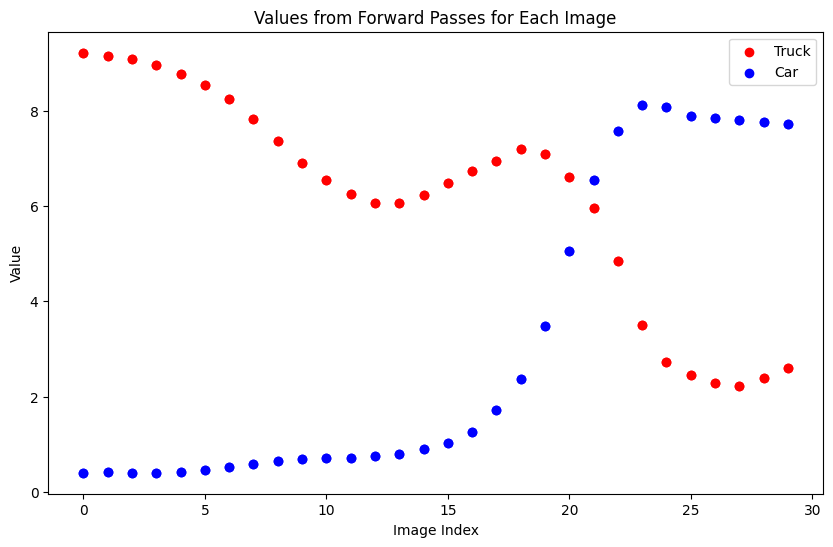

In [307]:
plt.figure(figsize=(10, 6))

for i in range(num_forward_passes):
    plt.scatter(range(num_images), truck_softmax_input[:, i], marker='o', c='r', label='Truck' if i == 0 else None)
    plt.scatter(range(num_images), car_softmax_input[:, i], marker='o', c='b', label='Car' if i == 0 else None)

# Label the axes
plt.xlabel('Image Index')
plt.ylabel('Value')
plt.title('Values from Forward Passes for Each Image')

# Add a legend
plt.legend()

# Show the plot
plt.show()

